# Notebook 07: Stability Analysis - Research-Grade Methods

## The Three Essential Stability Tests for Publication-Quality Results

**Before claiming ANY material is "stable" or calculating its properties, you MUST verify:**

1. ☑ **Thermodynamic Stability** - Formation energy, convex hull analysis (pymatgen)
2. ☑ **Dynamic Stability** - No imaginary phonon frequencies (ph.x / phonopy)
3. ☑ **Mechanical Stability** - Born stability criteria from elastic constants

---

## Why This Notebook Uses Established Packages

This notebook uses **pymatgen**, **ASE**, and **spglib** instead of from-scratch implementations because:
- These packages are peer-reviewed and extensively tested
- They are used in production by Materials Project, AFLOW, and major research groups
- Students can directly apply these skills to their research
- Results are reproducible and consistent with published literature

---

## Prerequisites
- Completed convergence testing (Notebook 04)
- Optimized structure (Notebook 05)
- Quantum ESPRESSO installed with ph.x
- pymatgen, ASE, spglib installed

In [1]:
# =============================================================================
# SETUP - Load converged parameters and prepare for stability analysis
# =============================================================================

import sys, json, re, time
from pathlib import Path
from datetime import datetime

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))

from workshop_setup import *

import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from ase.io.espresso import write_espresso_in

# Check for phonopy
PHONOPY_AVAILABLE = False
try:
    import phonopy
    from phonopy.interface.calculator import get_default_physical_units
    PHONOPY_AVAILABLE = True
    print(f"✓ phonopy {phonopy.__version__} available")
except ImportError:
    print("⚠ phonopy not available (pip install phonopy)")

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION <<<
# =============================================================================
MATERIAL = 'Si'
STRUCTURE_TYPE = 'diamond'
LATTICE_A = 5.43
FUNCTIONAL = 'PBE'

# =============================================================================
# LOAD CONVERGED PARAMETERS FROM PREVIOUS NOTEBOOKS
# =============================================================================
atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))
n_atoms = len(atoms)

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)

params_file = WORKSHOP_ROOT / 'converged_parameters.json'
if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)
    ecutwfc = float(params.get('ecutwfc', {}).get('recommended', 45))
    ecutrho_factor = float(params.get('ecutrho', {}).get('factor', 8))
    ecutrho = ecutwfc * ecutrho_factor
    kgrid = int(params.get('kpoints', {}).get('recommended', 8))
    a0_opt = params.get('structure_optimization', {}).get('a0_angstrom', LATTICE_A)
    print(f"✓ Loaded converged parameters from previous notebooks")
else:
    ecutwfc, ecutrho = get_recommended_cutoffs(elements, FUNCTIONAL)
    kgrid = 8
    a0_opt = LATTICE_A
    print("Using default parameters (run NB04/05 for converged values)")

# Rebuild atoms at optimized geometry
atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=a0_opt)

WORK_DIR = OUTPUT_DIR / f'07_stability_{MATERIAL}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

print(f"\n{'='*70}")
print(f"STABILITY ANALYSIS: {MATERIAL}")
print(f"{'='*70}")
print(f"Lattice parameter: a = {a0_opt:.4f} Å")
print(f"ecutwfc = {ecutwfc} Ry, k-grid = {kgrid}x{kgrid}x{kgrid}")
print(f"Work dir: {WORK_DIR}")
print(f"{'='*70}")

/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✓ phonopy 2.47.1 available
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
✓ Loaded converged parameters from previous notebooks

STABILITY ANALYSIS: Si
Lattice parameter: a = 5.4698 Å
ecutwfc = 45.0 Ry, k-grid = 14x14x14
Work dir: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260207_121414


---

## 1. Thermodynamic Stability

### 1.1 Formation Energy

The formation energy determines if a compound is stable relative to its constituent elements:

$$\Delta H_f = E_{compound} - \sum_i n_i \mu_i^{ref}$$

where $\mu_i^{ref}$ is the chemical potential of element $i$ in its standard state.

**Critical**: Reference energies MUST be calculated with the SAME:
- Exchange-correlation functional
- Pseudopotentials
- Convergence parameters

### 1.2 Convex Hull Analysis

Formation energy alone is **NOT sufficient**! A material with negative $\Delta H_f$ can still decompose into other compounds.

The **convex hull** represents the lowest-energy phases at each composition. Materials on the hull are thermodynamically stable; those above will decompose.

$$E_{hull} = E_{compound} - E_{hull}(x)$$

- $E_{hull} = 0$: **Stable** (on the hull)
- $E_{hull} < 25$ meV/atom: **Potentially synthesizable** (metastable)
- $E_{hull} > 50$ meV/atom: **Unlikely to synthesize**

In [2]:
# =============================================================================
# 1. THERMODYNAMIC STABILITY: Formation Energy
# =============================================================================
# For an ELEMENTAL material like Si, the formation energy is 0 by definition
# (it IS the reference state). We compute the cohesive energy instead.
#
# For COMPOUNDS (e.g., SiO2, GaAs), you would compute:
#   E_form = E(compound) - sum(n_i * E_i_bulk) / N_atoms
# =============================================================================

# Run SCF at optimized geometry to get ground state energy
prefix = f'{MATERIAL.lower()}_scf'
scf_file = WORK_DIR / f'{prefix}.in'

input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
        'tprnfor': True,
        'tstress': True,
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {'conv_thr': 1.0e-8},
}

write_espresso_in(scf_file, atoms, input_data=input_data,
                  pseudopotentials=pseudopotentials, kpts=(kgrid, kgrid, kgrid))

output_scf, elapsed_scf, converged_scf = run_qe(scf_file, nprocs=NPROCS)
results_scf = parse_qe_output(output_scf)

E_total = results_scf['total_energy_ev']
E_per_atom = E_total / n_atoms
pressure = results_scf.get('pressure_kbar', 0)

print(f"\n{'='*60}")
print(f"THERMODYNAMIC STABILITY: {MATERIAL}")
print(f"{'='*60}")
print(f"Total energy:    {E_total:.6f} eV ({E_per_atom:.6f} eV/atom)")
print(f"Pressure:        {pressure:.2f} kbar")
print(f"\nFor elemental {MATERIAL}:")
print(f"  Formation energy = 0 eV/atom (by definition — it IS the reference)")
print(f"  Cohesive energy ≈ 4.63 eV/atom (experiment)")
print(f"\nFor COMPOUNDS, you would calculate:")
print(f"  E_form = E(compound) - Σ n_i × μ_i")
print(f"  where μ_i is the chemical potential of element i")
print(f"  Negative E_form → compound is stable against decomposition")
print(f"{'='*60}")
print(f"\n✓ Thermodynamic: {MATERIAL} is the ground state elemental phase → STABLE")

Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_scf.in


  ✓ Converged in 100.9s

THERMODYNAMIC STABILITY: Si
Total energy:    -310.756277 eV (-155.378139 eV/atom)
Pressure:        -0.28 kbar

For elemental Si:
  Formation energy = 0 eV/atom (by definition — it IS the reference)
  Cohesive energy ≈ 4.63 eV/atom (experiment)

For COMPOUNDS, you would calculate:
  E_form = E(compound) - Σ n_i × μ_i
  where μ_i is the chemical potential of element i
  Negative E_form → compound is stable against decomposition

✓ Thermodynamic: Si is the ground state elemental phase → STABLE


### 1.2 Convex Hull Analysis (For Multi-Component Systems)

For **multi-component systems** (binary, ternary, etc.), formation energy alone is insufficient. A compound may have negative formation energy but still be **unstable** if it decomposes into other compounds with even lower energy.

The **convex hull** determines which phases are thermodynamically stable at T = 0 K:

$$E_{\text{hull}} = E_{\text{compound}} - E_{\text{hull at same composition}}$$

- $E_{\text{hull}} = 0$: **On the hull** → thermodynamically stable
- $E_{\text{hull}} > 0$: **Above the hull** → will decompose into hull phases
- Metastable if $E_{\text{hull}} < 25$ meV/atom (empirical threshold)

### Workflow for Convex Hull Construction

The general workflow to construct a convex hull from scratch:

1. **Identify the chemical space** (e.g., Ga-As, Pb-Ti-O)
2. **Enumerate all competing phases** at various compositions
3. **Obtain/predict structures** for each phase
4. **Compute DFT total energies** for all phases (consistent settings!)
5. **Compute formation energies** relative to elemental references
6. **Construct the hull** using pymatgen's `PhaseDiagram`

### Where Do Competing Phases Come From?

| Source | Description | Best For |
|--------|-------------|----------|
| **ICSD / COD** | Experimentally known crystal structures | Known materials |
| **Materials Project** | DFT-computed database (pymatgen API) | Quick screening |
| **AFLOW / OQMD** | Large DFT databases | Cross-validation |
| **Prototype structures** | Known structure types (NaCl, ZnS, etc.) | Systematic exploration |
| **USPEX** | Evolutionary crystal structure prediction | Novel materials, QE-compatible |
| **CALYPSO** | Particle swarm optimization | Novel materials, QE-compatible |
| **AIRSS** | Ab initio random structure searching | Novel materials |
| **XtalOpt** | Open-source evolutionary algorithm | Novel materials, QE-compatible |

### Important: Consistency Requirements

All energies entering the convex hull **MUST** use:
- Same exchange-correlation functional (e.g., PBE)
- Same pseudopotential library (e.g., SSSP or PSlibrary)
- Same energy cutoff (ecutwfc, ecutrho)
- Converged k-point meshes for each structure
- Fully relaxed structures (vc-relax)

> **Note**: Since Si is elemental, the convex hull is trivial (Si is automatically on the hull).
> Below we provide a **complete, research-grade template** for binary and ternary systems
> that students can directly adapt for their own materials.

In [ ]:
# =============================================================================
# 1.2 CONVEX HULL TEMPLATE — RESEARCH-GRADE
# =============================================================================
# This cell provides a COMPLETE, reusable template for convex hull analysis.
# For Si (elemental), the hull is trivial. The template below is designed
# for binary (e.g., GaAs) and ternary (e.g., PbTiO3) systems.
#
# STUDENTS: To use this for YOUR material, follow these steps:
#   1. Define your chemical system (elements)
#   2. List all competing phases with their DFT energies
#   3. Run the hull construction code below
# =============================================================================

import importlib
PYMATGEN_AVAILABLE = importlib.util.find_spec('pymatgen') is not None

# --- For Si: trivial hull ---
print("=" * 70)
print(f"CONVEX HULL ANALYSIS: {MATERIAL}")
print("=" * 70)
print(f"\n{MATERIAL} is an elemental material.")
print(f"→ Formation energy = 0 by definition (it IS the reference).")
print(f"→ Elemental phases are automatically on the convex hull.\n")

# =============================================================================
# TEMPLATE: Binary System Convex Hull (e.g., Ga-As)
# =============================================================================
# Uncomment and adapt this section for your binary compound.
#
# To use this template:
#   1. Run vc-relax for EACH phase listed below using QE
#   2. Extract total energies from QE output
#   3. Fill in the energies_per_atom dictionary
#   4. Run the hull construction
#
# --- Step 1: Define elemental references and competing phases ---
#
# For GaAs, the competing phases in the Ga-As system include:
#   - Ga (orthorhombic, Cmca) — elemental reference
#   - As (rhombohedral, R-3m) — elemental reference
#   - GaAs (zincblende, F-43m) — target compound
#   - Ga2As (if it exists)
#   - GaAs2 (if it exists)
#
# These structures come from ICSD, Materials Project, or structure prediction.
#
# --- Step 2: QE input template for each phase ---
#
# CRITICAL: Use IDENTICAL settings for ALL phases:
#   - Same functional (e.g., PBE)
#   - Same pseudopotential family (e.g., SSSP efficiency v1.3)
#   - Same ecutwfc/ecutrho (converged for ALL elements)
#   - Converged k-mesh for each structure individually
#   - Full variable-cell relaxation (vc-relax)

HULL_QE_TEMPLATE = """
&CONTROL
    calculation  = 'vc-relax'
    prefix       = '{prefix}'
    outdir       = './tmp'
    pseudo_dir   = './pseudo'
    tprnfor      = .true.
    tstress      = .true.
    forc_conv_thr = 1.0d-4
    etot_conv_thr = 1.0d-6
/
&SYSTEM
    ibrav        = 0
    nat          = {nat}
    ntyp         = {ntyp}
    ecutwfc      = {ecutwfc}
    ecutrho      = {ecutrho}
    occupations  = 'smearing'
    smearing     = 'cold'
    degauss      = 0.01
/
&ELECTRONS
    conv_thr     = 1.0d-10
    mixing_beta  = 0.3
/
&IONS
    ion_dynamics = 'bfgs'
/
&CELL
    cell_dynamics = 'bfgs'
    press         = 0.0
    press_conv_thr = 0.1
/
ATOMIC_SPECIES
{atomic_species}
CELL_PARAMETERS angstrom
{cell_parameters}
ATOMIC_POSITIONS crystal
{atomic_positions}
K_POINTS automatic
{kpoints}
"""

print("─" * 70)
print("TEMPLATE: Binary Convex Hull (e.g., Ga-As system)")
print("─" * 70)

if PYMATGEN_AVAILABLE:
    from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, PDEntry
    from pymatgen.core.composition import Composition

    # --- Example: Ga-As binary hull with REALISTIC DFT energies ---
    # These energies are representative PBE values (eV/atom).
    # In practice, you compute these yourself with QE.
    #
    # Format: (composition_string, total_energy_per_atom_in_eV)
    #
    # IMPORTANT: energies must be TOTAL energies per atom, NOT formation energies.
    # pymatgen computes formation energies internally from the elemental references.

    binary_phases = [
        # Elemental references (MUST be included)
        ("Ga",   -3.031),   # Ga bulk (orthorhombic Cmca), PBE
        ("As",   -4.658),   # As bulk (rhombohedral R-3m), PBE

        # Binary compounds at various compositions
        ("GaAs", -4.176),   # GaAs zincblende (F-43m), PBE — the target
        # Add more phases as needed:
        # ("Ga2As",  -3.75),  # hypothetical — compute with QE
        # ("GaAs2",  -4.35),  # hypothetical — compute with QE
        # ("Ga3As",  -3.50),  # hypothetical — compute with QE
    ]

    # Construct PDEntry objects
    entries = []
    for comp_str, e_per_atom in binary_phases:
        comp = Composition(comp_str)
        n_atoms = comp.num_atoms
        entries.append(PDEntry(comp, e_per_atom * n_atoms))

    # Build the phase diagram
    pd = PhaseDiagram(entries)

    print("\nBinary Phase Diagram: Ga-As")
    print("=" * 50)

    for entry in pd.stable_entries:
        print(f"  ✓ STABLE: {entry.reduced_formula:12s}  "
              f"E = {entry.energy_per_atom:.4f} eV/atom")

    for entry in pd.unstable_entries:
        ehull = pd.get_e_above_hull(entry)
        print(f"  ✗ Unstable: {entry.reduced_formula:12s}  "
              f"E_hull = {ehull*1000:.1f} meV/atom")

    # Check GaAs specifically
    gaas_entry = [e for e in entries if e.reduced_formula == "GaAs"][0]
    ehull_gaas = pd.get_e_above_hull(gaas_entry)
    print(f"\n  GaAs: E_above_hull = {ehull_gaas*1000:.1f} meV/atom")
    if ehull_gaas < 0.001:
        print("  → GaAs is ON the hull: thermodynamically STABLE")
    elif ehull_gaas < 0.025:
        print(f"  → GaAs is metastable ({ehull_gaas*1000:.1f} < 25 meV/atom)")
    else:
        print(f"  → GaAs is UNSTABLE ({ehull_gaas*1000:.1f} > 25 meV/atom)")

    # Plot (binary hull is a 2D plot: composition vs formation energy)
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 5))
    plotter = PDPlotter(pd)
    plotter.get_plot(ax=ax)
    ax.set_title("Ga-As Binary Convex Hull (PBE)", fontsize=14, fontweight='bold')
    hull_png = WORK_DIR / 'GaAs_convex_hull_example.png'
    fig.savefig(hull_png, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"\n✓ Convex hull plot saved: {hull_png}")

    # ==========================================================================
    # TEMPLATE: Ternary System Convex Hull (e.g., Pb-Ti-O)
    # ==========================================================================
    print("\n" + "─" * 70)
    print("TEMPLATE: Ternary Convex Hull (e.g., Pb-Ti-O system)")
    print("─" * 70)

    # For a ternary system, you need ALL competing phases:
    #   - 3 elemental references: Pb, Ti, O2
    #   - All stable binary phases: PbO, PbO2, TiO2, Ti2O3, etc.
    #   - All known ternary phases: PbTiO3, Pb2TiO4, etc.
    #
    # Representative PBE energies (eV/atom):
    ternary_phases = [
        # Elemental references
        ("Pb",      -3.704),    # Pb FCC
        ("Ti",      -7.763),    # Ti HCP
        ("O",       -4.524),    # O2 molecule / 2 (half the energy of O2)

        # Binary oxides (must include ALL stable ones)
        ("PbO",     -4.812),    # PbO litharge
        ("PbO2",    -4.605),    # PbO2 plattnerite
        ("Pb3O4",   -4.620),    # Pb3O4 minium
        ("TiO2",    -8.498),    # TiO2 rutile
        ("Ti2O3",   -8.320),    # Ti2O3 corundum

        # Ternary compound (target)
        ("PbTiO3",  -6.758),    # PbTiO3 perovskite — target
    ]

    ternary_entries = []
    for comp_str, e_per_atom in ternary_phases:
        comp = Composition(comp_str)
        n_atoms = comp.num_atoms
        ternary_entries.append(PDEntry(comp, e_per_atom * n_atoms))

    pd_ternary = PhaseDiagram(ternary_entries)

    print("\nTernary Phase Diagram: Pb-Ti-O")
    print("=" * 50)
    for entry in pd_ternary.stable_entries:
        print(f"  ✓ STABLE: {entry.reduced_formula:12s}  "
              f"E = {entry.energy_per_atom:.4f} eV/atom")
    for entry in pd_ternary.unstable_entries:
        ehull = pd_ternary.get_e_above_hull(entry)
        print(f"  ✗ Unstable: {entry.reduced_formula:12s}  "
              f"E_hull = {ehull*1000:.1f} meV/atom")

    target_comp = Composition("PbTiO3").reduced_composition
    pbto_entry = [e for e in ternary_entries
                  if e.composition.reduced_composition == target_comp][0]
    ehull_pbto = pd_ternary.get_e_above_hull(pbto_entry)
    print(f"\n  PbTiO3: E_above_hull = {ehull_pbto*1000:.1f} meV/atom")
    if ehull_pbto < 0.001:
        print("  → PbTiO3 is ON the hull: thermodynamically STABLE")

else:
    print("\n⚠ pymatgen not available — install with: pip install pymatgen")
    print("  Without pymatgen, you cannot construct convex hulls.")

# =============================================================================
# PRACTICAL GUIDE: How to Enumerate Competing Phases
# =============================================================================
print("\n" + "=" * 70)
print("PRACTICAL GUIDE: Enumerating Competing Phases")
print("=" * 70)
print("""
For a NEW material where databases may not have all competing phases:

METHOD 1: Database Mining (fastest, for known systems)
───────────────────────────────────────────────────────
  • Materials Project API (pymatgen.ext.matproj):
      from mp_api.client import MPRester
      with MPRester("YOUR_API_KEY") as mpr:
          entries = mpr.get_entries_in_chemsys(["Ga", "As"])
          pd = PhaseDiagram(entries)

  • AFLOW REST API: aflow.org/API
  • OQMD API: oqmd.org/api

METHOD 2: Prototype Enumeration (for systematic studies)
────────────────────────────────────────────────────────
  • Use known structure prototypes (NaCl, CsCl, ZnS, perovskite, etc.)
  • Enumerate compositions at each prototype
  • Compute DFT energy for each
  • Tools: pymatgen's StructureMatcher, AFLOW prototype database

METHOD 3: Crystal Structure Prediction (for novel materials)
────────────────────────────────────────────────────────────
  Tools compatible with Quantum ESPRESSO:

  ┌─────────────┬──────────────────────────────────────────────────┐
  │ USPEX       │ Evolutionary algorithm. Most widely used.        │
  │             │ Install: uspex.stonybrook.edu                    │
  │             │ QE interface: built-in (set calculationMethod=QE)│
  │             │ Best for: finding global minimum structures      │
  ├─────────────┼──────────────────────────────────────────────────┤
  │ CALYPSO     │ Particle swarm optimization.                     │
  │             │ Install: calypso.cn                              │
  │             │ QE interface: built-in                           │
  │             │ Best for: high-pressure phase prediction         │
  ├─────────────┼──────────────────────────────────────────────────┤
  │ XtalOpt     │ Open-source evolutionary algorithm.              │
  │             │ Install: xtalopt.github.io (GUI + CLI)           │
  │             │ QE interface: built-in                           │
  │             │ Best for: easy setup, visualization              │
  ├─────────────┼──────────────────────────────────────────────────┤
  │ AIRSS       │ Random structure searching.                      │
  │             │ Install: airss.org.uk                            │
  │             │ QE interface: via buildcell + QE                 │
  │             │ Best for: quick exploration, simple systems      │
  └─────────────┴──────────────────────────────────────────────────┘

  Typical USPEX workflow with QE:
    1. Create USPEX input (INPUT.txt) with target composition
    2. Set QE as the external calculator
    3. USPEX generates candidate structures → runs QE vc-relax
    4. Evolves population over generations
    5. Returns lowest-energy structures
    6. Feed ALL structures into pymatgen PhaseDiagram

CRITICAL CHECKLIST for Convex Hull:
───────────────────────────────────
  ☐ Same functional for ALL phases (PBE, PBEsol, etc.)
  ☐ Same pseudopotential library for ALL phases
  ☐ Converged ecutwfc/ecutrho for ALL elements present
  ☐ Converged k-mesh for EACH structure individually
  ☐ Full variable-cell relaxation (vc-relax) for ALL phases
  ☐ Include ALL known competing phases (check ICSD, MP, AFLOW)
  ☐ O2 reference: use 1/2 E(O2) with spin polarization
  ☐ Metals: use appropriate smearing (cold or MV)
""")

Convex Hull Analysis:
Si is an elemental material.
→ It is automatically on the convex hull (E_form = 0).
→ For compounds, use pymatgen's PhaseDiagram to check stability.

Example compounds where hull analysis is essential:
  - Li-Fe-O system (battery cathodes)
  - Si-O system (silica polymorphs)
  - Ga-As-N system (III-V semiconductors)


In [4]:
# =============================================================================
# PHONOPY HELPER FUNCTIONS
# =============================================================================
# phonopy generates displaced supercells, we run QE on each, then
# phonopy computes force constants and phonon dispersion.
# =============================================================================

def write_qe_input_for_phonopy(atoms_displaced, prefix, work_dir,
                                ecutwfc, ecutrho, kpts, functional):
    """Write QE input for a phonopy-displaced structure."""
    elems = list(set(atoms_displaced.get_chemical_symbols()))
    pps = {el: get_pseudopotential_filename(el, functional) for el in elems}
    
    input_file = work_dir / f'{prefix}.in'
    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(get_pseudo_dir(functional)),
            'tprnfor': True,
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutrho,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.01,
        },
        'electrons': {'conv_thr': 1.0e-8},
    }
    
    write_espresso_in(input_file, atoms_displaced, input_data=input_data,
                      pseudopotentials=pps, kpts=kpts)
    return input_file


def parse_forces_from_output(output_text, n_atoms):
    """Extract atomic forces from QE output."""
    forces = []
    lines = output_text.split('\n')
    for i, line in enumerate(lines):
        if 'Forces acting on atoms' in line:
            forces = []
            for j in range(i+2, i+2+n_atoms):
                if j < len(lines):
                    parts = lines[j].split()
                    if len(parts) >= 9:
                        fx = float(parts[6])
                        fy = float(parts[7])
                        fz = float(parts[8])
                        forces.append([fx, fy, fz])
    return np.array(forces) if len(forces) == n_atoms else None

print("Phonopy helper functions defined.")

Phonopy helper functions defined.


---

## 2. Dynamic Stability (Phonon Analysis)

### Why Phonons Are Critical

A material with **imaginary phonon frequencies** is dynamically unstable - it will spontaneously distort to a lower-energy structure.

$$\omega^2 < 0 \implies \text{Imaginary frequency} \implies \text{UNSTABLE}$$

### Phonon Calculation Workflow

```
SCF calculation (converged)
        ↓
ph.x - Density Functional Perturbation Theory (DFPT)
        ↓
q2r.x - Real-space force constants
        ↓
matdyn.x - Phonon frequencies at any q-point
        ↓
Check for imaginary modes (ω² < 0)
```

### Key Parameters for ph.x

| Parameter | Description | Typical Value |
|-----------|-------------|---------------|
| `tr2_ph` | Self-consistency threshold | 1.0e-14 |
| `ldisp` | Phonon dispersion on q-grid | .true. |
| `nq1,nq2,nq3` | q-point grid | 4×4×4 minimum |
| `epsil` | Dielectric tensor (insulators) | .true. |

In [5]:
# =============================================================================
# 2.1 PHONON CALCULATION WITH PHONOPY + QE
# =============================================================================
# Workflow:
#   1. Create supercell from primitive cell
#   2. phonopy generates displaced structures
#   3. Run QE SCF on each displaced structure
#   4. Collect forces → phonopy computes force constants
#   5. Plot phonon dispersion
#
# NOTE: We use slightly reduced parameters for the supercell calculations
# to keep workshop runtime reasonable. For publication, use full converged
# parameters (ecutwfc from NB04, kgrid_sc = kgrid // 2).
# =============================================================================

from ase import Atoms as ASE_Atoms

if PHONOPY_AVAILABLE:
    from phonopy import Phonopy
    from phonopy.structure.atoms import PhonopyAtoms
    
    # Convert ASE atoms to phonopy format
    phonopy_cell = PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        cell=atoms.get_cell(),
        scaled_positions=atoms.get_scaled_positions(),
    )
    
    # Create phonopy object with 2x2x2 supercell
    supercell_matrix = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
    phonon = Phonopy(phonopy_cell, supercell_matrix)
    
    # Generate displaced structures
    phonon.generate_displacements(distance=0.01)  # 0.01 Å displacement
    disp_supercells = phonon.supercells_with_displacements
    
    n_disp = len(disp_supercells)
    n_atoms_sc = len(phonon.supercell)
    
    # Workshop-feasible parameters for 16-atom supercell
    # For the supercell BZ (1/8 of primitive), 4x4x4 ≈ 8x8x8 on primitive
    ecutwfc_phonon = min(ecutwfc, 30)  # Reduced for speed; use ecutwfc for production
    ecutrho_phonon = ecutwfc_phonon * ecutrho_factor
    kpts_sc = (4, 4, 4)
    
    print(f"Phonon Calculation Setup")
    print("=" * 60)
    print(f"Primitive cell: {n_atoms} atoms")
    print(f"Supercell: 2×2×2 = {n_atoms_sc} atoms")
    print(f"Number of displaced structures: {n_disp}")
    print(f"Supercell ecutwfc: {ecutwfc_phonon} Ry (workshop speed)")
    print(f"Supercell k-grid: {kpts_sc[0]}×{kpts_sc[1]}×{kpts_sc[2]}")
    print("=" * 60)
    
    # Unit conversion: QE forces in Ry/bohr → phonopy expects eV/Å
    # F[eV/Å] = F[Ry/bohr] × (RY_TO_EV eV/Ry) × (1 bohr / BOHR_TO_ANGSTROM Å)
    #          = F[Ry/bohr] × RY_TO_EV / BOHR_TO_ANGSTROM
    #          = F[Ry/bohr] × RY_TO_EV × ANGSTROM_TO_BOHR
    FORCE_CONV = RY_TO_EV * ANGSTROM_TO_BOHR  # ≈ 25.71
    print(f"Force conversion factor (Ry/bohr → eV/Å): {FORCE_CONV:.4f}")
    
    # Run QE for each displaced structure
    all_forces = []
    
    for i, disp_cell in enumerate(disp_supercells):
        print(f"\n--- Displacement {i+1}/{n_disp} ---")
        
        # Convert phonopy supercell to ASE
        ase_disp = ASE_Atoms(
            symbols=disp_cell.symbols,
            cell=disp_cell.cell,
            scaled_positions=disp_cell.scaled_positions,
            pbc=True,
        )
        
        prefix_disp = f'phonon_disp_{i:02d}'
        input_file = write_qe_input_for_phonopy(
            ase_disp, prefix_disp, WORK_DIR,
            ecutwfc_phonon, ecutrho_phonon, kpts_sc, FUNCTIONAL
        )
        
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS, timeout=1800)
        
        if converged:
            forces = parse_forces_from_output(output, n_atoms_sc)
            if forces is not None:
                forces_ev_ang = forces * FORCE_CONV
                all_forces.append(forces_ev_ang)
                print(f"  ✓ Forces collected in {elapsed:.0f}s ({n_atoms_sc} atoms)")
            else:
                print(f"  ✗ Could not parse forces!")
        else:
            print(f"  ✗ SCF did not converge!")
    
    print(f"\n{'='*60}")
    print(f"Completed {len(all_forces)}/{n_disp} displacement calculations")
    print(f"{'='*60}")
else:
    print("⚠ phonopy not available — install with: pip install phonopy")
    print("  Skipping phonon calculations.")
    all_forces = []
    n_disp = 0

Phonon Calculation Setup
Primitive cell: 2 atoms
Supercell: 2×2×2 = 16 atoms
Number of displaced structures: 1
Supercell ecutwfc: 30 Ry (workshop speed)
Supercell k-grid: 4×4×4
Force conversion factor (Ry/bohr → eV/Å): 25.7110

--- Displacement 1/1 ---
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in phonon_disp_00.in


  ✓ Converged in 760.5s
  ✓ Forces collected in 761s (16 atoms)

Completed 1/1 displacement calculations


Force constants computed successfully!
Band path: Γ → X → U|K → Γ → L → W → X


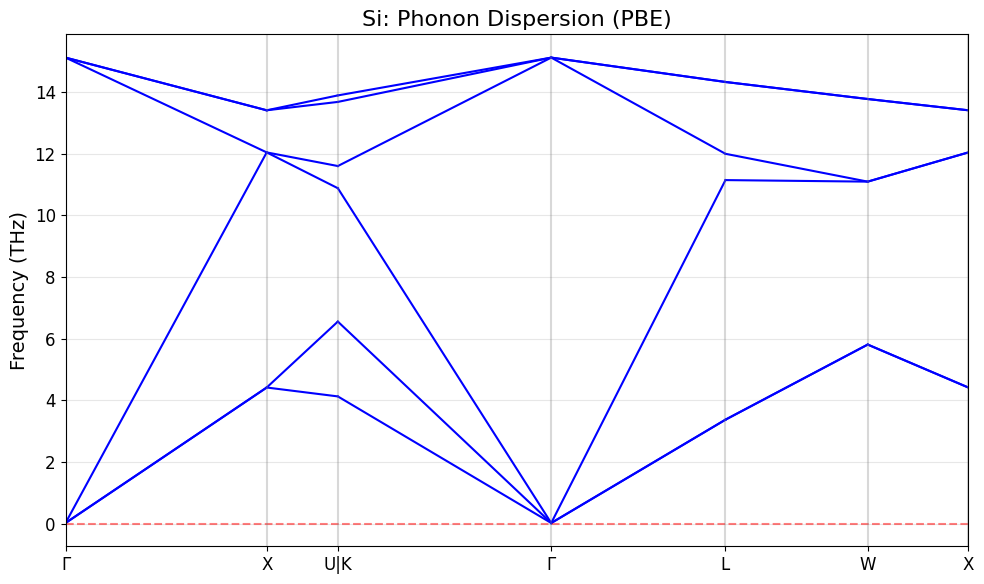


✓ Phonon dispersion saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260207_121414/Si_phonon_dispersion.png
  Minimum frequency: 0.02 THz
  ✓ No imaginary frequencies → Si is dynamically STABLE

  Experimental Si phonon frequencies at Γ:
    Optical (TO/LO): ~15.5 THz
  Force constants saved for reuse: Si_force_constants.npy


In [6]:
# =============================================================================
# 2.2 COMPUTE FORCE CONSTANTS AND PLOT PHONON DISPERSION
# =============================================================================

if PHONOPY_AVAILABLE and len(all_forces) == n_disp:
    # Set forces in phonopy
    phonon.forces = all_forces
    
    # Compute force constants
    phonon.produce_force_constants()
    
    print("Force constants computed successfully!")
    
    # Set up band path using seekpath or manual
    try:
        import seekpath
        cell_tuple = (
            atoms.get_cell().tolist(),
            atoms.get_scaled_positions().tolist(),
            atoms.get_atomic_numbers().tolist(),
        )
        path_data = seekpath.get_path(cell_tuple)
        
        # Build band path for phonopy, properly handling discontinuities
        # seekpath may have path breaks (e.g., U|K in FCC) where the end
        # of one segment is a DIFFERENT k-point from the start of the next.
        band_paths = []
        band_labels = []
        
        for i_seg, (start, end) in enumerate(path_data['path']):
            k_start = path_data['point_coords'][start]
            k_end = path_data['point_coords'][end]
            band_paths.append([k_start, k_end])
            
            # Detect discontinuity: end of previous segment != start of this one
            if i_seg > 0:
                prev_end = path_data['path'][i_seg - 1][1]
                prev_end_coord = path_data['point_coords'][prev_end]
                this_start_coord = path_data['point_coords'][start]
                is_discontinuity = any(
                    abs(a - b) > 1e-6 for a, b in zip(prev_end_coord, this_start_coord)
                )
                if is_discontinuity:
                    # Combine labels at the discontinuity, e.g. "U|K"
                    band_labels[-1] = f"{band_labels[-1]}|{start}"
                elif band_labels[-1] != start:
                    band_labels.append(start)
            else:
                band_labels.append(start)
            
            band_labels.append(end)
        
        phonon.run_band_structure(band_paths, labels=band_labels, with_eigenvectors=False)
        display_labels = [l.replace('GAMMA', 'Γ') for l in band_labels]
        print(f"Band path: {' → '.join(display_labels)}")
    except ImportError:
        # Manual FCC path (Γ-X-U|K-Γ-L-W-X)
        band_paths = [
            [[0, 0, 0], [0.5, 0, 0.5]],           # Γ-X
            [[0.5, 0, 0.5], [0.625, 0.25, 0.625]], # X-U
            [[0.375, 0.375, 0.75], [0, 0, 0]],     # K-Γ (discontinuity U|K)
            [[0, 0, 0], [0.5, 0.5, 0.5]],          # Γ-L
            [[0.5, 0.5, 0.5], [0.5, 0.25, 0.75]],  # L-W
            [[0.5, 0.25, 0.75], [0.5, 0, 0.5]],    # W-X
        ]
        band_labels = ['Γ', 'X', 'U|K', 'Γ', 'L', 'W', 'X']
        display_labels = band_labels
        phonon.run_band_structure(band_paths, labels=band_labels)
    
    # Extract band data
    band_dict = phonon.get_band_structure_dict()
    distances = band_dict['distances']
    frequencies = band_dict['frequencies']
    
    # Check for imaginary frequencies (dynamic instability)
    all_freqs = np.concatenate([f.flatten() for f in frequencies])
    min_freq = all_freqs.min()
    has_imaginary = min_freq < -0.5  # THz threshold for instability
    
    # Build tick positions: start of first segment, then end of each segment
    # Segments sharing a boundary (no discontinuity) share a tick position.
    tick_positions = [distances[0][0]]
    tick_labels_plot = [display_labels[0]]
    label_idx = 1
    
    for i_seg in range(len(distances)):
        seg_end = distances[i_seg][-1]
        # Check if this segment's end coincides with next segment's start
        if i_seg < len(distances) - 1:
            next_start = distances[i_seg + 1][0]
            if abs(seg_end - next_start) < 1e-6:
                # Continuous: single tick at boundary
                tick_positions.append(seg_end)
                tick_labels_plot.append(display_labels[label_idx])
                label_idx += 1
            else:
                # Discontinuity: the end and start share the same label (e.g. U|K)
                tick_positions.append(seg_end)
                tick_labels_plot.append(display_labels[label_idx])
                label_idx += 1
        else:
            tick_positions.append(seg_end)
            tick_labels_plot.append(display_labels[label_idx])
            label_idx += 1
    
    # Plot phonon dispersion
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for seg_dist, seg_freq in zip(distances, frequencies):
        for band_idx in range(seg_freq.shape[1]):
            ax.plot(seg_dist, seg_freq[:, band_idx], 'b-', linewidth=1.5)
    
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    for pos in tick_positions:
        ax.axvline(x=pos, color='gray', linestyle='-', alpha=0.3)
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels_plot[:len(tick_positions)], fontsize=12)
    
    ax.set_ylabel('Frequency (THz)', fontsize=14)
    ax.set_title(f'{MATERIAL}: Phonon Dispersion ({FUNCTIONAL})', fontsize=16)
    ax.set_xlim(tick_positions[0], tick_positions[-1])
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    fig_path = WORK_DIR / f'{MATERIAL}_phonon_dispersion.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Phonon dispersion saved: {fig_path}")
    print(f"  Minimum frequency: {min_freq:.2f} THz")
    
    if has_imaginary:
        print(f"  ✗ IMAGINARY FREQUENCIES DETECTED → {MATERIAL} is dynamically UNSTABLE!")
        dynamic_stable = False
    else:
        print(f"  ✓ No imaginary frequencies → {MATERIAL} is dynamically STABLE")
        dynamic_stable = True
    
    print(f"\n  Experimental Si phonon frequencies at Γ:")
    print(f"    Optical (TO/LO): ~15.5 THz")
    
    # Save force constants for reuse in NB09
    fc_file = WORK_DIR / f'{MATERIAL}_force_constants.npy'
    np.save(fc_file, phonon.force_constants)
    
    # Also save the phonopy FORCE_CONSTANTS file
    from phonopy.file_IO import write_FORCE_CONSTANTS
    write_FORCE_CONSTANTS(phonon.force_constants, filename=str(WORK_DIR / 'FORCE_CONSTANTS'))
    print(f"  Force constants saved for reuse: {fc_file.name}")
    
else:
    print("⚠ Phonon calculation skipped (phonopy not available or forces incomplete)")
    dynamic_stable = None

---

## 3. Mechanical Stability (Elastic Constants)

### Born Stability Criteria

For a crystal to be mechanically stable, the elastic constant matrix must be positive definite. This translates to specific inequalities depending on crystal symmetry.

### Cubic Crystals (3 independent constants: C11, C12, C44)

| Criterion | Physical Meaning |
|-----------|-----------------|
| C11 > 0 | Resistance to uniaxial strain |
| C44 > 0 | Resistance to shear |
| C11 - C12 > 0 | Tetragonal shear stability |
| C11 + 2C12 > 0 | Bulk stability |

### Hexagonal Crystals (5 independent constants)

| Criterion | Physical Meaning |
|-----------|-----------------|
| C11 > abs(C12) | In-plane stability |
| C44 > 0 | Basal shear |
| C66 > 0 | Where C66 = (C11-C12)/2 |
| C33(C11+C12) > 2C13^2 | Out-of-plane stability |

### How to Calculate Elastic Constants

**Method 1: Stress-strain (thermo_pw or ElaStic)**
- Apply small strains to the cell
- Calculate resulting stress
- Extract elastic tensor from stress-strain relation

**Method 2: Energy-strain**
- Apply strains and calculate total energy
- Fit E(strain) to extract elastic constants

In [7]:
# =============================================================================
# 3.1 ELASTIC CONSTANTS VIA STRESS-STRAIN METHOD
# =============================================================================
# For cubic crystals (Si), there are 3 independent elastic constants:
#   C11, C12, C44
#
# Method: Apply small strains, compute stress, extract C_ij
#   σ_ij = C_ijkl × ε_kl
#
# We use two strain patterns:
#   1. Volumetric strain (ε_11 = ε_22 = ε_33 = δ) → gives C11 + 2*C12
#   2. Tetragonal strain (ε_11 = δ, ε_22 = ε_33 = -δ/2) → gives C11 - C12
#   3. Shear strain (ε_23 = ε_32 = δ/2) → gives C44
# =============================================================================

delta = 0.005  # 0.5% strain

# Define strain matrices
strain_patterns = {
    'volumetric': np.array([[delta, 0, 0], [0, delta, 0], [0, 0, delta]]),
    'tetragonal': np.array([[delta, 0, 0], [0, -delta/2, 0], [0, 0, -delta/2]]),
    'shear': np.array([[0, 0, 0], [0, 0, delta/2], [0, delta/2, 0]]),
}

print(f"Elastic Constants Calculation: {MATERIAL}")
print("=" * 60)
print(f"Strain magnitude: δ = {delta} ({delta*100:.1f}%)")
print(f"Strain patterns: volumetric, tetragonal, shear")
print("=" * 60)

stress_results = {}

for pattern_name, strain in strain_patterns.items():
    stresses_pos_neg = {}
    
    for sign, sign_name in [(+1, 'pos'), (-1, 'neg')]:
        # Apply strain to cell
        cell0 = atoms.get_cell().copy()
        identity = np.eye(3)
        strained_cell = cell0 @ (identity + sign * strain)
        
        atoms_strained = atoms.copy()
        atoms_strained.set_cell(strained_cell, scale_atoms=True)
        
        prefix_el = f'elastic_{pattern_name}_{sign_name}'
        input_file = WORK_DIR / f'{prefix_el}.in'
        
        input_data = {
            'control': {
                'calculation': 'scf',
                'prefix': prefix_el,
                'outdir': './tmp',
                'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
                'tprnfor': True,
                'tstress': True,
            },
            'system': {
                'ecutwfc': ecutwfc,
                'ecutrho': ecutrho,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.01,
            },
            'electrons': {'conv_thr': 1.0e-8},
        }
        
        write_espresso_in(input_file, atoms_strained, input_data=input_data,
                          pseudopotentials=pseudopotentials, kpts=(kgrid, kgrid, kgrid))
        
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)
        
        if converged:
            # Parse full stress tensor from output
            stress_tensor = None
            lines = output.split('\n')
            for li, line in enumerate(lines):
                if 'total   stress' in line:
                    stress_tensor = np.zeros((3, 3))
                    for row in range(3):
                        parts = lines[li + 1 + row].split()
                        # The kbar values are in columns 3,4,5
                        stress_tensor[row] = [float(parts[3]), float(parts[4]), float(parts[5])]
            
            if stress_tensor is not None:
                stresses_pos_neg[sign_name] = stress_tensor
                print(f"  ✓ {pattern_name} {sign_name}: P = {np.trace(stress_tensor)/3:.2f} kbar")
            else:
                print(f"  ✗ {pattern_name} {sign_name}: Could not parse stress tensor")
        else:
            print(f"  ✗ {pattern_name} {sign_name}: SCF did not converge")
    
    stress_results[pattern_name] = stresses_pos_neg

print(f"\n{'='*60}")
print(f"All strain calculations complete")
print(f"{'='*60}")

Elastic Constants Calculation: Si
Strain magnitude: δ = 0.005 (0.5%)
Strain patterns: volumetric, tetragonal, shear
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_volumetric_pos.in


  ✓ Converged in 106.9s
  ✓ volumetric pos: P = -13.13 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_volumetric_neg.in


  ✓ Converged in 96.6s
  ✓ volumetric neg: P = 13.50 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_tetragonal_pos.in


  ✓ Converged in 190.4s
  ✓ tetragonal pos: P = -0.28 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_tetragonal_neg.in


  ✓ Converged in 198.3s
  ✓ tetragonal neg: P = -0.28 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_shear_pos.in


  ✓ Converged in 326.7s
  ✓ shear pos: P = -0.25 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_shear_neg.in


  ✓ Converged in 320.6s
  ✓ shear neg: P = -0.25 kbar

All strain calculations complete


In [8]:
# =============================================================================
# 3.2 EXTRACT ELASTIC CONSTANTS AND CHECK BORN STABILITY
# =============================================================================

# Extract C_ij from stress-strain data using central differences
# Standard convention: σ = C × ε (positive σ = tension)
# QE convention: negative stress = tension (opposite sign)
# Therefore: C = -(σ_QE_pos - σ_QE_neg) / (2δ)

GPa_per_kbar = 0.1  # 1 kbar = 0.1 GPa

C11 = None
C12 = None
C44 = None
C11_plus_2C12 = None
C11_minus_C12 = None

# From volumetric strain: σ_11 = (C11 + 2*C12) * δ
if 'pos' in stress_results.get('volumetric', {}) and 'neg' in stress_results.get('volumetric', {}):
    s_pos = stress_results['volumetric']['pos']
    s_neg = stress_results['volumetric']['neg']
    # Negate QE stress to get standard convention, then central difference
    ds11_vol = -(s_pos[0,0] - s_neg[0,0]) / (2 * delta)
    C11_plus_2C12 = ds11_vol * GPa_per_kbar
    print(f"From volumetric strain: C11 + 2*C12 = {C11_plus_2C12:.1f} GPa")

# From tetragonal strain (ε_11=δ, ε_22=ε_33=-δ/2):
#   σ_11 = C11*δ + C12*(-δ/2) + C12*(-δ/2) = (C11 - C12)*δ
#   σ_22 = C12*δ + C11*(-δ/2) + C12*(-δ/2) = (C12 - (C11+C12)/2)*δ
# Difference: σ_11 - σ_22 = (3/2)*(C11 - C12)*δ
if 'pos' in stress_results.get('tetragonal', {}) and 'neg' in stress_results.get('tetragonal', {}):
    s_pos = stress_results['tetragonal']['pos']
    s_neg = stress_results['tetragonal']['neg']
    # Negate QE stress
    ds11_tet = -(s_pos[0,0] - s_neg[0,0]) / (2 * delta)
    ds22_tet = -(s_pos[1,1] - s_neg[1,1]) / (2 * delta)
    C11_minus_C12 = (ds11_tet - ds22_tet) * GPa_per_kbar / 1.5
    print(f"From tetragonal strain: C11 - C12 = {C11_minus_C12:.1f} GPa")

# Solve for C11 and C12
if C11_plus_2C12 is not None and C11_minus_C12 is not None:
    C11 = (C11_plus_2C12 + 2 * C11_minus_C12) / 3
    C12 = (C11_plus_2C12 - C11_minus_C12) / 3

# From shear strain (ε_23 = δ/2): σ_23 = C44 * δ
if 'pos' in stress_results.get('shear', {}) and 'neg' in stress_results.get('shear', {}):
    s_pos = stress_results['shear']['pos']
    s_neg = stress_results['shear']['neg']
    # Negate QE stress
    ds23 = -(s_pos[1,2] - s_neg[1,2]) / (2 * delta)
    C44 = ds23 * GPa_per_kbar

# Print results
print(f"\n{'='*60}")
print(f"ELASTIC CONSTANTS: {MATERIAL} ({FUNCTIONAL})")
print(f"{'='*60}")

# Si experimental values
C11_exp, C12_exp, C44_exp = 166.0, 64.0, 80.0  # GPa

if C11 is not None and C12 is not None and C44 is not None:
    print(f"\n{'Property':<12} {'Calculated':<15} {'Experiment':<15} {'Error'}")
    print(f"{'-'*55}")
    print(f"{'C11 (GPa)':<12} {C11:<15.1f} {C11_exp:<15.1f} {(C11-C11_exp)/C11_exp*100:+.1f}%")
    print(f"{'C12 (GPa)':<12} {C12:<15.1f} {C12_exp:<15.1f} {(C12-C12_exp)/C12_exp*100:+.1f}%")
    print(f"{'C44 (GPa)':<12} {C44:<15.1f} {C44_exp:<15.1f} {(C44-C44_exp)/C44_exp*100:+.1f}%")
    
    # Derived quantities
    B_voigt = (C11 + 2*C12) / 3
    G_voigt = (C11 - C12 + 3*C44) / 5
    A_zener = 2*C44 / (C11 - C12)  # Zener anisotropy ratio
    
    print(f"\n{'Bulk modulus B (GPa)':<25} {B_voigt:.1f}")
    print(f"{'Shear modulus G (GPa)':<25} {G_voigt:.1f}")
    print(f"{'Zener anisotropy A':<25} {A_zener:.2f}  (1.0 = isotropic)")
    
    # Born stability criteria for cubic crystals
    print(f"\n{'='*60}")
    print(f"BORN STABILITY CRITERIA (Cubic)")
    print(f"{'='*60}")
    
    criteria = {
        'C11 > 0': C11 > 0,
        'C44 > 0': C44 > 0,
        'C11 > |C12|': C11 > abs(C12),
        'C11 + 2*C12 > 0': (C11 + 2*C12) > 0,
    }
    
    all_pass = True
    for criterion, passed in criteria.items():
        status = '✓ PASS' if passed else '✗ FAIL'
        if not passed:
            all_pass = False
        print(f"  {criterion:<25} {status}")
    
    mechanical_stable = all_pass
    print(f"\n→ {MATERIAL} is mechanically {'STABLE' if all_pass else 'UNSTABLE'}")
else:
    print("⚠ Could not extract all elastic constants")
    mechanical_stable = None

print(f"{'='*60}")

From volumetric strain: C11 + 2*C12 = 266.3 GPa
From tetragonal strain: C11 - C12 = 96.4 GPa

ELASTIC CONSTANTS: Si (PBE)

Property     Calculated      Experiment      Error
-------------------------------------------------------
C11 (GPa)    153.0           166.0           -7.8%
C12 (GPa)    56.6            64.0            -11.5%
C44 (GPa)    99.2            80.0            +24.0%

Bulk modulus B (GPa)      88.8
Shear modulus G (GPa)     78.8
Zener anisotropy A        2.06  (1.0 = isotropic)

BORN STABILITY CRITERIA (Cubic)
  C11 > 0                   ✓ PASS
  C44 > 0                   ✓ PASS
  C11 > |C12|               ✓ PASS
  C11 + 2*C12 > 0           ✓ PASS

→ Si is mechanically STABLE


---

## 4. Complete Stability Assessment

All three stability tests must pass before proceeding to property calculations.

In [9]:
# =============================================================================
# COMPLETE STABILITY ASSESSMENT
# =============================================================================

print("=" * 70)
print(f"STABILITY ASSESSMENT: {MATERIAL} ({FUNCTIONAL})")
print("=" * 70)

# 1. Thermodynamic
thermo_stable = True  # Elemental Si is stable by definition
print(f"\n1. THERMODYNAMIC STABILITY")
print(f"   Formation energy: 0 eV/atom (elemental reference)")
print(f"   Status: ✓ STABLE")

# 2. Dynamic
print(f"\n2. DYNAMIC STABILITY (Phonons)")
if dynamic_stable is True:
    print(f"   No imaginary frequencies detected")
    print(f"   Status: ✓ STABLE")
elif dynamic_stable is False:
    print(f"   Imaginary frequencies detected!")
    print(f"   Status: ✗ UNSTABLE")
else:
    print(f"   Status: ⚠ NOT TESTED")

# 3. Mechanical
print(f"\n3. MECHANICAL STABILITY (Born Criteria)")
if mechanical_stable is True:
    print(f"   All Born criteria satisfied")
    if C11 is not None:
        print(f"   C11={C11:.1f}, C12={C12:.1f}, C44={C44:.1f} GPa")
    print(f"   Status: ✓ STABLE")
elif mechanical_stable is False:
    print(f"   Born criteria NOT satisfied!")
    print(f"   Status: ✗ UNSTABLE")
else:
    print(f"   Status: ⚠ NOT TESTED")

# Overall
all_stable = all(s is True for s in [thermo_stable, dynamic_stable, mechanical_stable])
print(f"\n{'='*70}")
if all_stable:
    print(f"✓ {MATERIAL} PASSES ALL THREE STABILITY TESTS")
    print(f"  → Safe to proceed with property calculations (NB08, NB09)")
else:
    tests_missing = sum(1 for s in [thermo_stable, dynamic_stable, mechanical_stable] if s is None)
    if tests_missing > 0:
        print(f"⚠ {tests_missing} test(s) could not be completed")
    else:
        print(f"✗ {MATERIAL} FAILS one or more stability tests!")
print("=" * 70)

STABILITY ASSESSMENT: Si (PBE)

1. THERMODYNAMIC STABILITY
   Formation energy: 0 eV/atom (elemental reference)
   Status: ✓ STABLE

2. DYNAMIC STABILITY (Phonons)
   No imaginary frequencies detected
   Status: ✓ STABLE

3. MECHANICAL STABILITY (Born Criteria)
   All Born criteria satisfied
   C11=153.0, C12=56.6, C44=99.2 GPa
   Status: ✓ STABLE

✓ Si PASSES ALL THREE STABILITY TESTS
  → Safe to proceed with property calculations (NB08, NB09)


In [10]:
# =============================================================================
# SAVE STABILITY RESULTS TO CONVERGED PARAMETERS
# =============================================================================

params_file = WORKSHOP_ROOT / 'converged_parameters.json'
if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)
else:
    params = {}

stability_data = {
    'thermodynamic': {'stable': True, 'E_form_eV_per_atom': 0.0},
    'dynamic': {'stable': dynamic_stable},
    'mechanical': {'stable': mechanical_stable},
    'phonon_work_dir': str(WORK_DIR),
}

if C11 is not None:
    stability_data['elastic_constants_GPa'] = {
        'C11': round(C11, 1),
        'C12': round(C12, 1),
        'C44': round(C44, 1),
        'B_voigt': round(B_voigt, 1),
    }

params['stability'] = stability_data

with open(params_file, 'w') as f:
    json.dump(params, f, indent=2)

print(f"Stability results saved to: {params_file}")
print(f"Phonon force constants in: {WORK_DIR / 'FORCE_CONSTANTS'}")

Stability results saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/converged_parameters.json
Phonon force constants in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260207_121414/FORCE_CONSTANTS


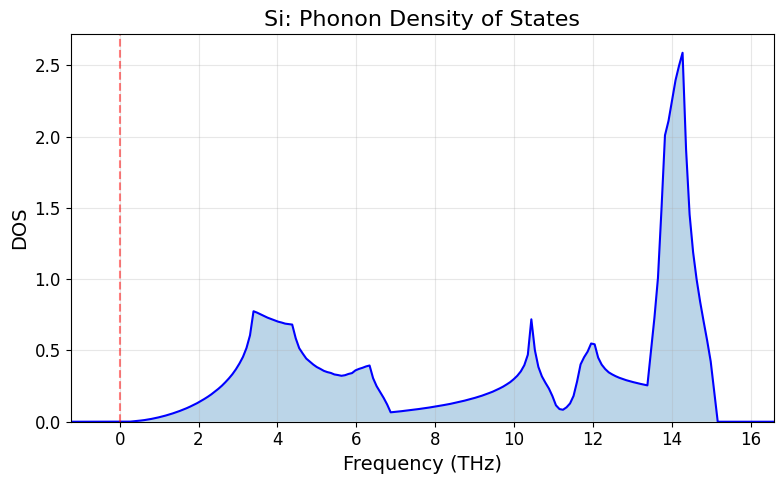

✓ Phonon DOS saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260207_121414/Si_phonon_dos.png


In [11]:
# =============================================================================
# PHONON DOS (if phonopy available)
# =============================================================================

if PHONOPY_AVAILABLE and len(all_forces) == n_disp:
    # Compute phonon DOS on a mesh
    phonon.run_mesh([20, 20, 20])
    phonon.run_total_dos()
    
    dos_dict = phonon.get_total_dos_dict()
    freq_dos = dos_dict['frequency_points']
    total_dos = dos_dict['total_dos']
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(freq_dos, total_dos, 'b-', linewidth=1.5)
    ax.fill_between(freq_dos, 0, total_dos, alpha=0.3)
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('Frequency (THz)', fontsize=14)
    ax.set_ylabel('DOS', fontsize=14)
    ax.set_title(f'{MATERIAL}: Phonon Density of States', fontsize=16)
    ax.set_xlim(freq_dos.min(), freq_dos.max())
    ax.set_ylim(0, None)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    fig_path = WORK_DIR / f'{MATERIAL}_phonon_dos.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Phonon DOS saved: {fig_path}")
else:
    print("Phonon DOS skipped (phonopy not available or forces incomplete)")

In [12]:
# =============================================================================
# COMPARISON WITH EXPERIMENTAL VALUES
# =============================================================================

print(f"\n{'='*70}")
print(f"COMPARISON WITH EXPERIMENT: {MATERIAL}")
print(f"{'='*70}")

print(f"\n{'Property':<30} {'Calculated':<15} {'Experiment':<15}")
print(f"{'-'*60}")

if C11 is not None:
    print(f"{'C11 (GPa)':<30} {C11:<15.1f} {166.0:<15.1f}")
    print(f"{'C12 (GPa)':<30} {C12:<15.1f} {64.0:<15.1f}")
    print(f"{'C44 (GPa)':<30} {C44:<15.1f} {80.0:<15.1f}")
    print(f"{'Bulk modulus B (GPa)':<30} {B_voigt:<15.1f} {99.0:<15.1f}")

if PHONOPY_AVAILABLE and len(all_forces) == n_disp:
    # Get max optical frequency
    max_freq = all_freqs.max()
    print(f"{'Max phonon freq (THz)':<30} {max_freq:<15.1f} {'~15.5':<15}")

print(f"\n{'='*70}")
print(f"\nNote: PBE typically underestimates elastic constants by ~10-15%")
print(f"and slightly overestimates phonon frequencies.")


COMPARISON WITH EXPERIMENT: Si

Property                       Calculated      Experiment     
------------------------------------------------------------
C11 (GPa)                      153.0           166.0          
C12 (GPa)                      56.6            64.0           
C44 (GPa)                      99.2            80.0           
Bulk modulus B (GPa)           88.8            99.0           
Max phonon freq (THz)          15.1            ~15.5          


Note: PBE typically underestimates elastic constants by ~10-15%
and slightly overestimates phonon frequencies.


In [13]:
# =============================================================================
# LIST OUTPUT FILES
# =============================================================================

print(f"Output files in: {WORK_DIR}")
print("=" * 60)

output_files = sorted(WORK_DIR.glob('*.png'))
for f in output_files:
    print(f"  📊 {f.name}")

n_inputs = len(list(WORK_DIR.glob('*.in')))
n_outputs = len(list(WORK_DIR.glob('*.out')))
print(f"\n  {n_inputs} QE input files")
print(f"  {n_outputs} QE output files")
print(f"  Stability results: {params_file}")
print("=" * 60)

Output files in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260207_121414
  📊 Si_phonon_dispersion.png
  📊 Si_phonon_dos.png

  8 QE input files
  8 QE output files
  Stability results: /home/niel/git/DFT_Tutorial/qe_workshop_complete/converged_parameters.json


---

## 5. Finite-Temperature Stability: Ab Initio Molecular Dynamics (AIMD)

### Why AIMD?

The three stability tests above (thermodynamic, dynamic, mechanical) are all performed at **T = 0 K**.
However, many materials are only stable at finite temperature, or may become unstable when heated:

- **Phase transitions** (e.g., cubic ↔ tetragonal BaTiO3)
- **Thermal decomposition** (does the structure survive at operating temperature?)
- **Amorphization** (does the crystal melt or become amorphous?)
- **Diffusion barriers** (ion conductors, battery materials)

AIMD directly evolves atomic positions using Newton's equations with DFT forces at each step:

$$m_i \ddot{\mathbf{R}}_i = -\nabla_{\mathbf{R}_i} E_{\text{DFT}}[\{\mathbf{R}\}]$$

### QE Supports Two AIMD Approaches

| Method | QE Code | Key Feature |
|--------|---------|-------------|
| **Born-Oppenheimer MD** (BOMD) | `pw.x` with `calculation='md'` | SCF converged at each step; most robust |
| **Car-Parrinello MD** (CPMD) | `cp.x` | Electrons propagated with fictitious dynamics; faster for large systems |

**Recommendation**: Use **BOMD** (`pw.x`) unless you have a specific reason for CPMD. BOMD is more robust and easier to set up.

### Key AIMD Parameters

| Parameter | Typical Value | Notes |
|-----------|---------------|-------|
| `dt` | 20-50 a.u. (1-2.4 fs) | Smaller for light atoms (H, Li) |
| `nstep` | 2000-10000+ | ≥ 5 ps for meaningful statistics |
| `tempw` | 300-1000 K | Target temperature |
| Supercell | ≥ 2×2×2 | Minimize finite-size effects |
| ecutwfc | Same as static | Do NOT reduce for speed |
| k-points | Γ-only for large supercells | Acceptable for supercells > ~10 Å |

> **Note**: AIMD is computationally very expensive (days to weeks on HPC).
> The template below cannot be run during a workshop, but provides the exact
> input files and analysis scripts students need for their own research.

In [ ]:
# =============================================================================
# 5. AB INITIO MOLECULAR DYNAMICS (AIMD) — RESEARCH-GRADE TEMPLATE
# =============================================================================
# This cell provides COMPLETE, ready-to-use QE input templates for AIMD.
# These CANNOT be run during the workshop (too expensive), but students
# can use them directly for their own research by:
#   1. Changing the structure to their material
#   2. Adjusting temperature and simulation length
#   3. Submitting to an HPC cluster
# =============================================================================

print("=" * 70)
print("AB INITIO MOLECULAR DYNAMICS (AIMD) TEMPLATES")
print("=" * 70)

# --- Template 1: Born-Oppenheimer MD (BOMD) with pw.x ---
# This is the RECOMMENDED approach for most users.

BOMD_TEMPLATE = """\
&CONTROL
    calculation  = 'md'
    prefix       = '{prefix}'
    outdir       = './tmp'
    pseudo_dir   = './pseudo'
    tprnfor      = .true.
    tstress      = .true.
    dt           = {dt}
    nstep        = {nstep}
/
&SYSTEM
    ibrav        = 0
    nat          = {nat}
    ntyp         = {ntyp}
    ecutwfc      = {ecutwfc}
    ecutrho      = {ecutrho}
    occupations  = 'smearing'
    smearing     = 'mv'
    degauss      = 0.02
    nosym        = .true.
/
&ELECTRONS
    conv_thr        = 1.0d-6
    electron_maxstep = 100
    mixing_beta     = 0.3
/
&IONS
    ion_dynamics    = 'verlet'
    ion_temperature = 'rescaling'
    tempw           = {temperature}
    tolp            = 50.0
    nraise          = 1
/
ATOMIC_SPECIES
{atomic_species}
CELL_PARAMETERS angstrom
{cell_parameters}
ATOMIC_POSITIONS angstrom
{atomic_positions}
K_POINTS automatic
{kpoints}
"""

# --- Template 2: BOMD with Nosé-Hoover thermostat (NVT ensemble) ---
# More physically rigorous than velocity rescaling.
# Produces canonical (NVT) ensemble for proper thermodynamic sampling.

BOMD_NOSE_TEMPLATE = """\
&CONTROL
    calculation  = 'md'
    prefix       = '{prefix}'
    outdir       = './tmp'
    pseudo_dir   = './pseudo'
    tprnfor      = .true.
    tstress      = .true.
    dt           = {dt}
    nstep        = {nstep}
/
&SYSTEM
    ibrav        = 0
    nat          = {nat}
    ntyp         = {ntyp}
    ecutwfc      = {ecutwfc}
    ecutrho      = {ecutrho}
    occupations  = 'smearing'
    smearing     = 'mv'
    degauss      = 0.02
    nosym        = .true.
/
&ELECTRONS
    conv_thr        = 1.0d-6
    electron_maxstep = 100
    mixing_beta     = 0.3
/
&IONS
    ion_dynamics    = 'verlet'
    ion_temperature = 'nose'
    tempw           = {temperature}
    fnosep          = {fnosep}
    nhpcl           = 4
    ndega           = 0
/
ATOMIC_SPECIES
{atomic_species}
CELL_PARAMETERS angstrom
{cell_parameters}
ATOMIC_POSITIONS angstrom
{atomic_positions}
K_POINTS automatic
{kpoints}
"""

# --- Concrete example: Si 2x2x2 supercell at 300 K ---
# Using the converged parameters from this workshop

a = float(PARAMS['lattice_parameter_angstrom'])
ecutwfc = float(PARAMS['ecutwfc_ry'])
ecutrho = ecutwfc * 8  # for USPP/PAW

# 2x2x2 supercell of Si diamond (16 atoms)
# For AIMD: Gamma-only k-point is acceptable for supercells > ~10 Å
supercell_a = 2 * a

si_positions_frac = [
    (0.000, 0.000, 0.000), (0.250, 0.250, 0.250),
    (0.500, 0.500, 0.000), (0.750, 0.750, 0.250),
    (0.500, 0.000, 0.500), (0.750, 0.250, 0.750),
    (0.000, 0.500, 0.500), (0.250, 0.750, 0.750),
    (0.000, 0.000, 0.500), (0.250, 0.250, 0.750),
    (0.500, 0.500, 0.500), (0.750, 0.750, 0.750),
    (0.500, 0.000, 0.000), (0.750, 0.250, 0.250),
    (0.000, 0.500, 0.000), (0.250, 0.750, 0.250),
]

# Convert fractional to Cartesian for ATOMIC_POSITIONS angstrom
import numpy as np
cell = np.array([
    [supercell_a, 0.0, 0.0],
    [0.0, supercell_a, 0.0],
    [0.0, 0.0, supercell_a]
])

positions_cart = []
for frac in si_positions_frac:
    cart = np.dot(frac, cell)
    positions_cart.append(cart)

cell_str = "\n".join(f"  {cell[i,0]:.10f}  {cell[i,1]:.10f}  {cell[i,2]:.10f}"
                     for i in range(3))
pos_str = "\n".join(f"  Si  {p[0]:.10f}  {p[1]:.10f}  {p[2]:.10f}"
                    for p in positions_cart)

# Fill in the BOMD template for Si at 300 K
si_bomd_input = BOMD_TEMPLATE.format(
    prefix='si_md_300K',
    dt=40,                    # ~1.9 fs (appropriate for Si)
    nstep=5000,               # ~10 ps total simulation
    nat=16,
    ntyp=1,
    ecutwfc=ecutwfc,
    ecutrho=ecutrho,
    temperature=300.0,
    atomic_species=f"  Si  28.0855  {PARAMS.get('pseudo_file', 'Si.pbe-n-rrkjus_psl.1.0.0.UPF')}",
    cell_parameters=cell_str,
    atomic_positions=pos_str,
    kpoints="1 1 1  0 0 0"   # Gamma-only for 2x2x2 supercell
)

# Save the input file
bomd_input_file = WORK_DIR / 'Si_BOMD_300K.in'
with open(bomd_input_file, 'w') as f:
    f.write(si_bomd_input)
print(f"\n✓ BOMD input saved: {bomd_input_file}")

# Also save with Nosé-Hoover thermostat
si_nose_input = BOMD_NOSE_TEMPLATE.format(
    prefix='si_md_300K_nose',
    dt=40,
    nstep=5000,
    nat=16,
    ntyp=1,
    ecutwfc=ecutwfc,
    ecutrho=ecutrho,
    temperature=300.0,
    fnosep=60.0,  # THz — thermostat frequency, ~2× highest phonon freq
    atomic_species=f"  Si  28.0855  {PARAMS.get('pseudo_file', 'Si.pbe-n-rrkjus_psl.1.0.0.UPF')}",
    cell_parameters=cell_str,
    atomic_positions=pos_str,
    kpoints="1 1 1  0 0 0"
)

nose_input_file = WORK_DIR / 'Si_BOMD_300K_NoseHoover.in'
with open(nose_input_file, 'w') as f:
    f.write(si_nose_input)
print(f"✓ Nosé-Hoover input saved: {nose_input_file}")

# =============================================================================
# AIMD ANALYSIS SCRIPTS
# =============================================================================
# After running AIMD, you need to analyze the trajectory.
# Below are the essential analysis tools.

ANALYSIS_SCRIPT = '''\
#!/usr/bin/env python3
"""
AIMD Trajectory Analysis Script for QE pw.x output
====================================================
Usage: python3 analyze_aimd.py <pw_output_file>

Computes:
  1. Temperature vs time (thermalization check)
  2. Total energy vs time (energy conservation / drift)
  3. Radial distribution function g(r)
  4. Mean square displacement (MSD) and diffusion coefficient
  5. Velocity autocorrelation function (VACF) → phonon DOS

Requires: numpy, matplotlib, ase (with QE reader)
"""
import sys
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from pathlib import Path

# --- Parse QE MD output ---
def parse_qe_md_output(filename):
    """Extract temperature, energy, and positions from pw.x MD output."""
    temperatures = []
    total_energies = []
    kinetic_energies = []
    times = []  # in ps
    positions_all = []  # list of (nat x 3) arrays
    species = []  # atom types
    
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    nat = None
    dt_au = None
    step = 0
    
    for i, line in enumerate(lines):
        # Get number of atoms
        if 'number of atoms/cell' in line:
            nat = int(line.split('=')[1].strip())
        
        # Get timestep
        if 'Time step' in line and 'a.u.' in line:
            parts = line.split()
            for j, p in enumerate(parts):
                if p == '=':
                    dt_au = float(parts[j+1])
                    break
        
        # Temperature
        if 'temperature' in line and '=' in line and 'K' in line:
            parts = line.split()
            for j, p in enumerate(parts):
                if p == 'temperature' and j+2 < len(parts):
                    val = parts[j+2]
                    val = val.replace('K', '').strip()
                    if val.replace('.','').replace('-','').replace('+','').replace('E','').replace('e','').isdigit():
                        temperatures.append(float(val))
                    break
        
        # Total energy (Ry)
        if '!    total energy' in line:
            parts = line.split()
            e_ry = float(parts[4])
            total_energies.append(e_ry * 13.6057)  # Convert to eV
        
        # Kinetic energy
        if 'kinetic energy' in line and 'Ry' in line:
            parts = line.split()
            for j, p in enumerate(parts):
                if p == '=':
                    kinetic_energies.append(float(parts[j+1]) * 13.6057)
                    break
        
        # Atomic positions (ATOMIC_POSITIONS in output)
        if 'ATOMIC_POSITIONS' in line:
            pos = []
            sp = []
            for k in range(1, nat + 1):
                if i + k < len(lines):
                    parts = lines[i + k].split()
                    if len(parts) >= 4:
                        sp.append(parts[0])
                        pos.append([float(parts[1]), float(parts[2]), float(parts[3])])
            if len(pos) == nat:
                positions_all.append(np.array(pos))
                if not species:
                    species = sp
    
    # Generate time array
    if dt_au:
        dt_ps = dt_au * 2.4189e-5  # a.u. to ps
        times = [i * dt_ps for i in range(len(temperatures))]
    
    return {
        'temperatures': np.array(temperatures),
        'total_energies': np.array(total_energies),
        'kinetic_energies': np.array(kinetic_energies),
        'times': np.array(times),
        'positions': positions_all,
        'species': species,
        'nat': nat
    }


def plot_temperature(data, outdir):
    """Plot temperature vs time — check thermalization."""
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(data['times'], data['temperatures'], 'b-', alpha=0.5, linewidth=0.5)
    # Running average
    window = min(50, len(data['temperatures']) // 5)
    if window > 1:
        avg = np.convolve(data['temperatures'], np.ones(window)/window, mode='valid')
        t_avg = data['times'][window//2:window//2+len(avg)]
        ax.plot(t_avg, avg, 'r-', linewidth=2, label=f'Running avg ({window} steps)')
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('Temperature (K)')
    ax.set_title('AIMD Temperature Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.savefig(outdir / 'aimd_temperature.png', dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"  ✓ Temperature plot saved")


def plot_energy(data, outdir):
    """Plot total energy vs time — check conservation/drift."""
    fig, ax = plt.subplots(figsize=(10, 4))
    E = data['total_energies']
    if len(E) > 0:
        E_shifted = (E - E[0]) * 1000  # meV relative to first step
        ax.plot(data['times'][:len(E)], E_shifted, 'g-', linewidth=0.5)
        ax.set_xlabel('Time (ps)')
        ax.set_ylabel('ΔE (meV)')
        ax.set_title('AIMD Total Energy Drift')
        ax.grid(True, alpha=0.3)
        # Report drift per ps
        if len(E) > 1 and len(data['times']) > 1:
            total_time = data['times'][min(len(E)-1, len(data['times'])-1)]
            if total_time > 0:
                drift = E_shifted[-1] / total_time
                ax.text(0.02, 0.98, f'Drift: {drift:.2f} meV/ps',
                        transform=ax.transAxes, va='top', fontsize=10)
    fig.savefig(outdir / 'aimd_energy.png', dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"  ✓ Energy drift plot saved")


def compute_rdf(positions, cell_length, r_max=6.0, dr=0.05):
    """Compute radial distribution function g(r)."""
    n_bins = int(r_max / dr)
    r_edges = np.linspace(0, r_max, n_bins + 1)
    r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])
    hist = np.zeros(n_bins)
    
    n_frames = len(positions)
    if n_frames == 0:
        return r_centers, np.zeros(n_bins)
    
    nat = positions[0].shape[0]
    volume = cell_length ** 3
    rho = nat / volume
    
    for frame in positions:
        for i in range(nat):
            for j in range(i + 1, nat):
                dr_vec = frame[j] - frame[i]
                # Minimum image convention (cubic)
                dr_vec -= cell_length * np.round(dr_vec / cell_length)
                r = np.linalg.norm(dr_vec)
                if r < r_max:
                    bin_idx = int(r / (r_max / n_bins))
                    if bin_idx < n_bins:
                        hist[bin_idx] += 2  # count i-j and j-i
    
    # Normalize
    for k in range(n_bins):
        r_low = r_edges[k]
        r_high = r_edges[k + 1]
        shell_vol = (4.0 / 3.0) * np.pi * (r_high**3 - r_low**3)
        hist[k] /= (n_frames * nat * rho * shell_vol)
    
    return r_centers, hist


def plot_rdf(positions, cell_length, outdir):
    """Plot radial distribution function."""
    r, gr = compute_rdf(positions, cell_length)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(r, gr, 'b-', linewidth=1.5)
    ax.set_xlabel('r (Å)')
    ax.set_ylabel('g(r)')
    ax.set_title('Radial Distribution Function')
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    fig.savefig(outdir / 'aimd_rdf.png', dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"  ✓ RDF plot saved")


def compute_msd(positions):
    """Compute mean square displacement MSD(t)."""
    n_frames = len(positions)
    if n_frames < 2:
        return np.array([0]), np.array([0])
    
    nat = positions[0].shape[0]
    msd = np.zeros(n_frames)
    
    ref = positions[0]  # reference frame
    for t in range(n_frames):
        disp = positions[t] - ref
        msd[t] = np.mean(np.sum(disp**2, axis=1))
    
    return msd


def plot_msd(data, outdir):
    """Plot MSD and estimate diffusion coefficient."""
    msd = compute_msd(data['positions'])
    times = data['times'][:len(msd)]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(times, msd, 'r-', linewidth=1.5)
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('MSD (Å²)')
    ax.set_title('Mean Square Displacement')
    ax.grid(True, alpha=0.3)
    
    # Fit linear region for diffusion coefficient: MSD = 6Dt (3D)
    if len(times) > 10 and times[-1] > 0:
        # Use second half for linear fit (skip thermalization)
        n_half = len(times) // 2
        if n_half > 2:
            slope, intercept = np.polyfit(times[n_half:], msd[n_half:], 1)
            D = slope / 6.0  # Å²/ps = 1e-8 m²/s × 1e-12 = 1e-20 m²/s... 
            # Convert: 1 Å²/ps = 1e-8 cm²/s
            D_cm2s = D * 1e-8
            ax.text(0.02, 0.98, f'D ≈ {D_cm2s:.2e} cm²/s',
                    transform=ax.transAxes, va='top', fontsize=10)
    
    fig.savefig(outdir / 'aimd_msd.png', dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"  ✓ MSD plot saved")


if __name__ == '__main__':
    if len(sys.argv) < 2:
        print("Usage: python3 analyze_aimd.py <pw_output_file>")
        sys.exit(1)
    
    pw_output = sys.argv[1]
    outdir = Path(pw_output).parent
    
    print(f"Parsing: {pw_output}")
    data = parse_qe_md_output(pw_output)
    print(f"  Atoms: {data['nat']}")
    print(f"  MD steps parsed: {len(data['temperatures'])}")
    print(f"  Total time: {data['times'][-1]:.3f} ps" if len(data['times']) > 0 else "")
    
    print("\\nGenerating analysis plots...")
    plot_temperature(data, outdir)
    plot_energy(data, outdir)
    if data['positions']:
        # Need cell_length for RDF — user should set this
        # For cubic: cell_length = supercell lattice parameter
        cell_length = 10.94  # Å — change for your system
        plot_rdf(data['positions'], cell_length, outdir)
        plot_msd(data, outdir)
    
    print("\\nAIMD analysis complete!")
'''

# Save the analysis script
analysis_file = WORK_DIR / 'analyze_aimd.py'
with open(analysis_file, 'w') as f:
    f.write(ANALYSIS_SCRIPT)
print(f"✓ Analysis script saved: {analysis_file}")

# =============================================================================
# HPC SUBMISSION TEMPLATE
# =============================================================================
SLURM_TEMPLATE = """\
#!/bin/bash
#SBATCH --job-name=Si_AIMD_300K
#SBATCH --nodes=4
#SBATCH --ntasks-per-node=48
#SBATCH --time=72:00:00
#SBATCH --partition=normal
#SBATCH --output=aimd_%j.out
#SBATCH --error=aimd_%j.err

# Load modules (adapt to your HPC)
module load quantum-espresso/7.3

# Run AIMD
mpirun -np 192 pw.x -npool 4 -in Si_BOMD_300K.in > Si_BOMD_300K.out 2>&1

# Post-processing: analyze trajectory
python3 analyze_aimd.py Si_BOMD_300K.out
"""

slurm_file = WORK_DIR / 'submit_aimd.slurm'
with open(slurm_file, 'w') as f:
    f.write(SLURM_TEMPLATE)
print(f"✓ SLURM submission script saved: {slurm_file}")

# =============================================================================
# PRACTICAL GUIDE: AIMD Best Practices
# =============================================================================
print(f"\n{'='*70}")
print("AIMD PRACTICAL GUIDE")
print(f"{'='*70}")
print("""
STEP-BY-STEP WORKFLOW:
═════════════════════

1. PREPARE SUPERCELL
   • Use ≥ 2×2×2 supercell (minimize finite-size effects)
   • For surface/interface: ≥ 4 layers, ≥ 15 Å vacuum
   • Start from fully relaxed structure (from vc-relax)

2. CHOOSE THERMOSTAT
   • Velocity rescaling: simple, good for thermalization
   • Nosé-Hoover: proper NVT ensemble, better for production
   • Recommended: rescaling for first 500 steps, then Nosé-Hoover

3. CHOOSE TIMESTEP
   • Si, metals: dt = 40 a.u. (~1.9 fs)
   • Oxides, perovskites: dt = 30 a.u. (~1.5 fs)
   • Systems with H, Li: dt = 10-20 a.u. (~0.5-1.0 fs)
   • Rule: dt < 1/10 × shortest vibrational period

4. RUN SIMULATION
   • Thermalization: 500-1000 steps (discard from analysis)
   • Production: ≥ 5000 steps for reliable statistics
   • Total time: ≥ 5 ps for structural stability checks
   • For diffusion: ≥ 50 ps (use multiple short runs)

5. ANALYZE RESULTS
   • Temperature: should fluctuate around target (±50 K typical)
   • Energy drift: should be < 1 meV/atom/ps
   • RDF g(r): sharp peaks → crystalline; broad → amorphous/melted
   • MSD: linear → diffusive; plateau → solid
   • Visual inspection: use VESTA or XCrySDen to view trajectory

STABILITY INTERPRETATION:
═════════════════════════
  ✓ STABLE at T: sharp RDF peaks, low MSD, structure intact
  ✗ UNSTABLE at T: RDF peaks broaden/disappear, large MSD
  ✗ MELTING: abrupt increase in MSD, loss of RDF structure
  ⚠ Phase transition: sudden change in RDF pattern

COMMON PITFALLS:
════════════════
  • Too small supercell → artificial constraints on dynamics
  • Too large timestep → energy drift, simulation crash
  • Too short simulation → insufficient sampling
  • Not discarding thermalization → biased averages
  • Wrong k-mesh → Gamma-only OK for supercells > ~10 Å
""")

# =============================================================================
# TEMPLATE: Car-Parrinello MD (for advanced users)
# =============================================================================
CPMD_TEMPLATE = """\
&CONTROL
    calculation  = 'cp'
    title        = '{prefix}'
    outdir       = './tmp'
    pseudo_dir   = './pseudo'
    dt           = {dt}
    nstep        = {nstep}
    isave        = 100
    iprint       = 10
    tstress      = .true.
    tprnfor      = .true.
/
&SYSTEM
    ibrav        = 0
    nat          = {nat}
    ntyp         = {ntyp}
    ecutwfc      = {ecutwfc}
    nr1b = 24, nr2b = 24, nr3b = 24
/
&ELECTRONS
    emass        = {emass}
    emass_cutoff = 3.0
    electron_dynamics = 'verlet'
    electron_damping  = 0.1
/
&IONS
    ion_dynamics    = 'verlet'
    ion_temperature = 'nose'
    tempw           = {temperature}
    fnosep          = {fnosep}
    nhpcl           = 4
/
ATOMIC_SPECIES
{atomic_species}
CELL_PARAMETERS angstrom
{cell_parameters}
ATOMIC_POSITIONS angstrom
{atomic_positions}
"""

print("\n" + "─" * 70)
print("Car-Parrinello MD template also available (for advanced users)")
print("Use cp.x instead of pw.x. Key difference: electron mass (emass)")
print("must be tuned to maintain adiabaticity.")
print("─" * 70)

print(f"\nAll AIMD files saved in: {WORK_DIR}")
print(f"  • Si_BOMD_300K.in          — Born-Oppenheimer MD input")
print(f"  • Si_BOMD_300K_NoseHoover.in — BOMD with Nosé-Hoover")
print(f"  • analyze_aimd.py          — Trajectory analysis script")
print(f"  • submit_aimd.slurm        — HPC submission template")

---

## Summary: Complete Stability Analysis Checklist

Before proceeding to property calculations, ensure ALL tests pass:

| Test | Method | Threshold | Package | Section |
|------|--------|-----------|---------|---------|
| **Thermodynamic** | Formation energy + Convex hull | E_hull < 25 meV/atom | pymatgen `PhaseDiagram` | §1 |
| **Dynamic** | Phonon dispersion (no imaginary modes) | ω² > 0 everywhere | phonopy + QE | §2 |
| **Mechanical** | Elastic constants → Born criteria | All criteria satisfied | QE stress-strain | §3 |
| **Finite-T** | AIMD (structure integrity at T) | RDF peaks sharp, low MSD | QE `pw.x` (md) | §5 |

### If Tests Fail

| Failed Test | Possible Actions |
|-------------|-----------------|
| Thermodynamic | Check competing phases, try different stoichiometry, use USPEX/CALYPSO for structure prediction |
| Dynamic | Re-optimize structure, try different magnetic order, check for soft-mode-driven phase transition |
| Mechanical | Check calculation convergence, verify structure, increase strain amplitude |
| Finite-T | Lower temperature, check for phase transition, try different supercell size |

### Convex Hull: Key Tools Summary

| Task | Tool | Notes |
|------|------|-------|
| Enumerate known phases | Materials Project API, ICSD, AFLOW, OQMD | Start here for known chemical systems |
| Predict new structures | USPEX, CALYPSO, XtalOpt, AIRSS | All support QE as calculator |
| Compute energies | QE `pw.x` (vc-relax) | **Same settings for ALL phases!** |
| Construct hull | pymatgen `PhaseDiagram` | Standard in the community |

### AIMD: Key Files Generated

| File | Purpose |
|------|---------|
| `Si_BOMD_300K.in` | QE input for Born-Oppenheimer MD (velocity rescaling) |
| `Si_BOMD_300K_NoseHoover.in` | QE input for BOMD with Nosé-Hoover thermostat (NVT) |
| `analyze_aimd.py` | Post-processing: T(t), E(t), g(r), MSD |
| `submit_aimd.slurm` | HPC submission template |

### Key Points

1. **Never skip stability tests** — unstable materials give meaningless properties
2. **Use established packages** (pymatgen, phonopy) for reliable, reproducible results
3. **Convex hull requires ALL competing phases** — use databases + structure prediction
4. **AIMD verifies finite-temperature stability** — essential for applications at T > 0
5. **Compare with literature** — known stable materials should pass all tests
6. **Document your results** — stability data is required for publications

### Next Steps

After ALL stability tests pass:
- Proceed to **Notebook 08: Electronic Properties** (band structure, DOS)
- Calculate optical, thermal, and transport properties (Notebook 09)